In [2]:
import pandas as pd
import os
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt

from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage

rcParams['figure.figsize'] = 10, 6
plt.style.use('Solarize_Light2')

5087 rows and 3198 columns

In [3]:
ROOT_DIR = os.path.abspath(".././")
test_data = pd.read_csv(os.path.join(ROOT_DIR, "data", "exoTest.csv")).fillna(0)
train_data = pd.read_csv(os.path.join(ROOT_DIR, "data", "exoTrain.csv")).fillna(0)
#print(train_data.head())
#print(test_data.head())

In [4]:
# rename the labels
# 0 indicates non-exoplanet star
# 1 indicates exoplanet star
label = {1: 0, 2: 1}

train_data.LABEL = [label[item] for item in train_data.LABEL]
test_data.LABEL = [label[item] for item in test_data.LABEL]

#print(train_data.head())
#print(test_data.head())

In [5]:
# check if there is any feature with constant value through different stars
# and drop the columns
#print(train_data.nunique())
counts = train_data.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# no constant column for these dataset
print("Columns to be deleted\n")
print(to_del)


Columns to be deleted

[]


# Memory Usage
Reduce the memory usage of the dataframe by converting data types into smaller data types.

In [6]:

def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


train_date = reduce_memory(train_data)
test_data = reduce_memory(test_data)

Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%
Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%


Plot the class distribution of stars to understand the ratio between them.

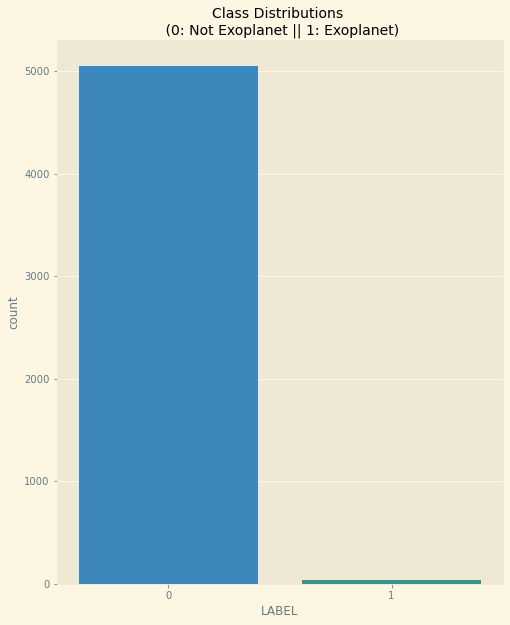

In [7]:
plt.figure(figsize=(8,10))
colors = ["0", "1"]
sns.color_palette("Set2", 8)
sns.countplot(x='LABEL', data=train_data)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
plt.show()

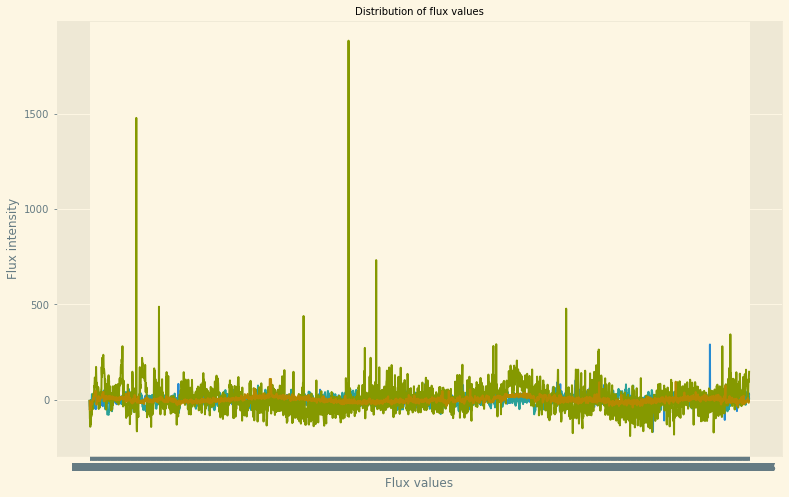

In [8]:
from pylab import rcParams
import random
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
rand_stars = list()
random.seed(27)
for i in range(4):
    rand_stars.append(random.randint(0, train_data.shape[0]))
plt.plot(train_data.iloc[rand_stars[0],])
plt.plot(train_data.iloc[rand_stars[1],])
plt.plot(train_data.iloc[rand_stars[2],])
plt.plot(train_data.iloc[rand_stars[3],])
plt.show()

# Data Normalization
Considering above graph of flux values, some of the flux values has a wider range than others which suppresses the effect of other features. Therefore our dataset needs to be normalized.

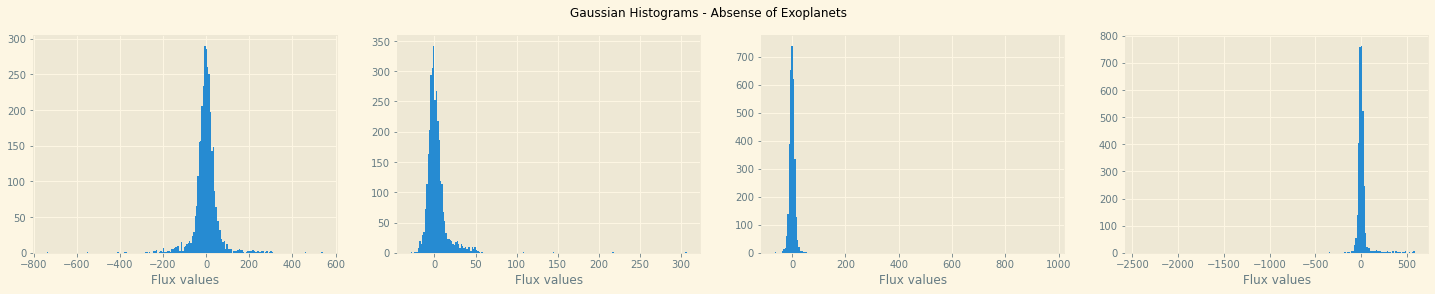

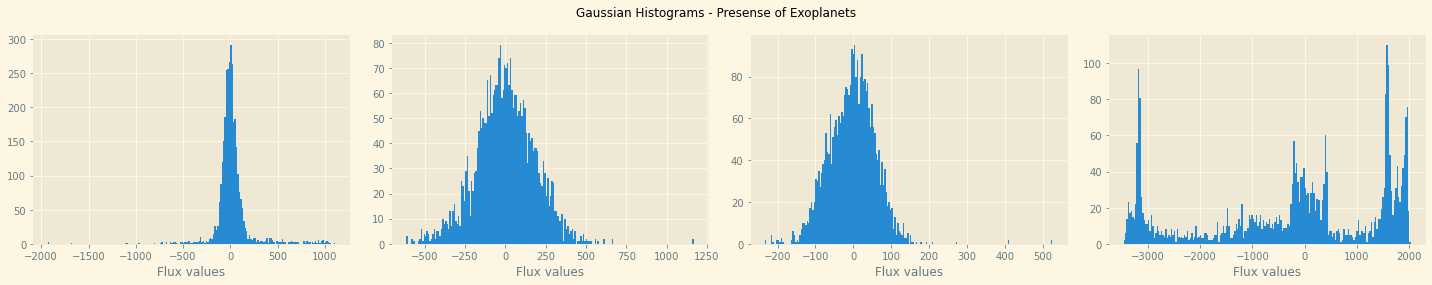

In [9]:
from pylab import rcParams

rcParams['figure.figsize'] = 25, 4
fig, axs = plt.subplots(1,4)
fig.suptitle("Gaussian Histograms - Absense of Exoplanets")
axs[0].hist(train_data.iloc[44,:], bins=200)
axs[0].set_xlabel("Flux values")
axs[1].hist(train_data.iloc[47,:], bins=200)
axs[1].set_xlabel("Flux values")
axs[2].hist(train_data.iloc[60,:], bins=200)
axs[2].set_xlabel("Flux values")
axs[3].hist(train_data.iloc[299,:], bins=200)
axs[3].set_xlabel("Flux values")


rcParams['figure.figsize'] = 20, 4
fig, axs = plt.subplots(1,4)
fig.suptitle("Gaussian Histograms - Presense of Exoplanets")
axs[0].hist(train_data.iloc[10,:], bins=200)
axs[0].set_xlabel("Flux values")
axs[1].hist(train_data.iloc[19,:], bins=200)
axs[1].set_xlabel("Flux values")
axs[2].hist(train_data.iloc[24,:], bins=200)
axs[2].set_xlabel("Flux values")
axs[3].hist(train_data.iloc[30,:], bins=200)
axs[3].set_xlabel("Flux values")

plt.tight_layout()

In [10]:
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

Normalize each sample independently (default axis is 1).

In [11]:
print("Flux values before normalization")
print(x_train.iloc[0:5,])
x_train = normalized = normalize(x_train) 
x_test = normalize(x_test)
print("Flux values after normalization")
print(x_train[0:5])

Flux values before normalization
        FLUX.1       FLUX.2       FLUX.3       FLUX.4       FLUX.5  \
0    93.849998    83.809998    20.100000   -26.980000   -39.560001   
1   -38.880001   -33.830002   -58.540001   -40.090000   -79.309998   
2   532.640015   535.919983   513.729980   496.920013   456.450012   
3   326.519989   347.390015   302.350006   298.130005   317.739990   
4 -1107.209961 -1112.589966 -1118.949951 -1095.099976 -1057.550049   

        FLUX.6      FLUX.7       FLUX.8      FLUX.9     FLUX.10  ...  \
0  -124.709999 -135.179993   -96.269997  -79.889999 -160.169998  ...   
1   -72.809998  -86.550003   -85.330002  -83.970001  -73.379997  ...   
2   466.000000  464.500000   486.390015  436.559998  484.390015  ...   
3   312.700012  322.329987   311.309998  312.420013  323.329987  ...   
4 -1034.479980 -998.340027 -1022.710022 -989.570007 -970.880005  ...   

    FLUX.3188   FLUX.3189   FLUX.3190   FLUX.3191   FLUX.3192   FLUX.3193  \
0  -78.070000 -102.150002 -102.15000

In [12]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)
print(x_train)

[[ 0.000754    0.00075759  0.00076465 ...  0.00021917  0.000254
   0.00027153]
 [ 0.00068916  0.00069267  0.00069961 ...  0.00022835  0.00026324
   0.00028081]
 [ 0.00056236  0.00056572  0.00057236 ...  0.00024618  0.00028119
   0.00029882]
 ...
 [ 0.01227879  0.01223416  0.0121462  ... -0.0014328  -0.00144865
  -0.00145686]
 [ 0.0125752   0.01252967  0.01243992 ... -0.00135485 -0.0013702
  -0.00137816]
 [ 0.0127252   0.01267922  0.01258856 ... -0.00131554 -0.00133064
  -0.00133846]]


Next step, data is standardized since our attribution distribution is Gaussion.

In [13]:
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)
print("Data after standardization: ")
print(x_train)

Data after standardization: 
[[ 0.15685749  0.15709266  0.15753295 ... -0.54823685 -0.53487396
  -0.52814114]
 [ 0.14612748  0.1463192   0.14667368 ... -0.54421026 -0.53083116
  -0.5240899 ]
 [ 0.12514697  0.1252505   0.12543076 ... -0.53638697 -0.5229764
  -0.5162188 ]
 ...
 [ 2.0637712   2.0617208   2.0576317  ... -1.273148   -1.2798492
  -1.2832644 ]
 [ 2.1128154   2.110763    2.1066673  ... -1.2389443  -1.2455249
  -1.2488792 ]
 [ 2.137636    2.1355817   2.1314816  ... -1.2216945  -1.2282134
  -1.2315366 ]]


# Dimentionality Reduction

There are **3198** features particularly for this dataset. To deal with the excessive number of features, our model should be provided with the subset of these features which would provide nearly the same amount of information with a lesser number of features. This is where the **Dimentionality Reduction** comes into play.

First, we need to determine the number of features that would be enough to classify our data using **PCA** which is the *Principal Component Analysis*.

In [25]:
from sklearn.decomposition import PCA # import PCA
pca = PCA()
x_train = pca.fit_transform(x_train)

"""
Do not fit the test data since including the test dataset
in the transform computation will allow information
to flow from the test data to the train data which
would distort the accuracy we will obtain from models

"""
x_test = pca.transform(x_test) 
total=sum(pca.explained_variance_)
k=0
current_variance=0
"""
After tranforming the data, PCA gives us the explained
variance of each feature. We should obtain a cumulative
sum of features with total variance ratio of 90%.
"""
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

print("Number of features after PCA: ", k)
N_FEATURES = k

Number of features after PCA:  10


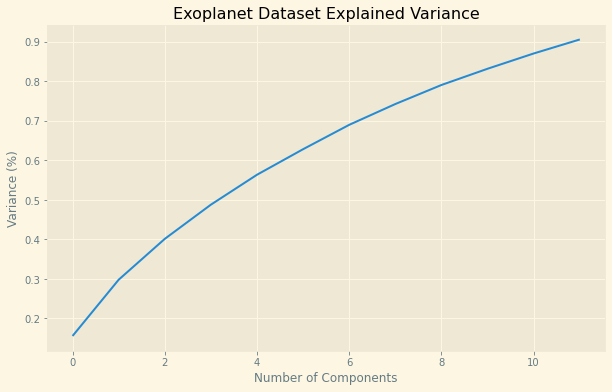

In [19]:
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
#Apply PCA with n_componenets
pca = PCA(n_components=N_FEATURES)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

## Classification

Based on how effective SVM is in high dimensional spaces, dataset was trained and tested with different configurations of SVM: *C value and kernel*. Even though the model did give
high accuracies with each possible pairs, the best parameters were **C = 1 and kernel = rbf**.


In [27]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

"""
Ignore ill-defined scores warning since the model
did not predict any data as false-positive or false-negative
"""
import warnings
warnings.filterwarnings('ignore')


param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1) 
   
# fit the model with train data
grid.fit(x_train, y_train) 
 
# print the best parameters after tuning 
print("Best parameters: ", grid.best_params_) 
grid_predictions = grid.predict(x_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



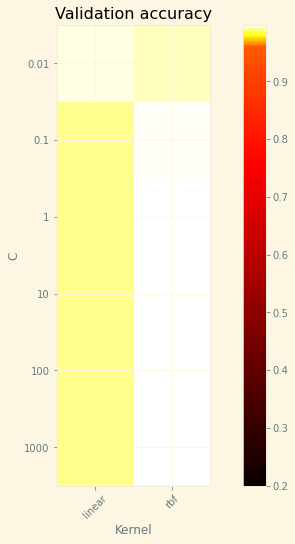

In [37]:
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



scores = grid.cv_results_['mean_test_score'].reshape(6, 2)

""" 
Draw heatmap of the validation accuracy as a function of C and kernel function.
The score are encoded as colors with the hot colormap which varies from dark
red to bright yellow. As the most all of the scores are located in the
0.95 to 0.99 range, a custom normalizer is used to set the mid-point to 0.95 so
as to make it easier to visualize the small variations of score values in the
interesting range while not brutally collapsing all the low score values to
the same color.
"""

plt.figure(figsize=(12,8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.2, midpoint=0.95))
plt.xlabel('Kernel')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['kernel'])), param_grid['kernel'], rotation=45)
plt.yticks(np.arange(len(param_grid["C"])), param_grid["C"])
plt.title('Validation accuracy')
plt.show()

Considering the heatmap above which displays accuracies of the model with different configurations, we can deduce that exoplanets dataset that is used in this model is linearly seperable with couple of points in the gutter since low values of C also gave high accuracies.